In [53]:
import sqlite3
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, adfuller


warnings.filterwarnings('ignore')

def get_data(msa: str) -> pd.DataFrame:
    msa = msa.lower()
    conn = sqlite3.connect('../db/realestate.db')
    query = f"SELECT name, date, total from building_permits where lower(name) like '%{msa}%'"

    df = pd.read_sql_query(query, conn)
    conn.close()

    print(df['name'].unique())

    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    return df

def resample_data(df: pd.DataFrame, how: str = 'sum', rule: str = 'Q') -> pd.DataFrame: 
    diff_data = df['total'].resample(rule=rule).mean().ffill()
    return diff_data

['Atlanta-Sandy Springs-Marietta, GA' 'Atlanta-Sandy Springs-Roswell, GA'
 'Atlanta-Sandy Springs-Alpharetta, GA']


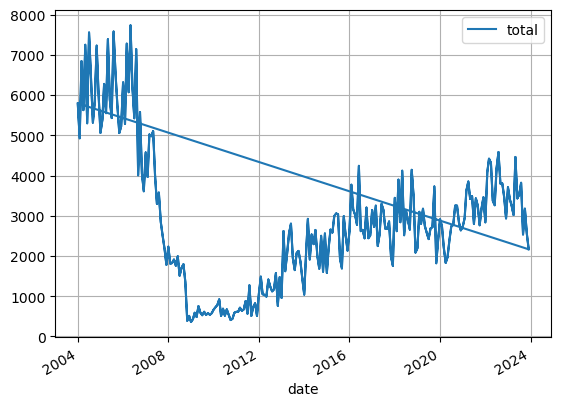

In [54]:
data = get_data('atlanta')
data.plot(grid=True)
plt.show()

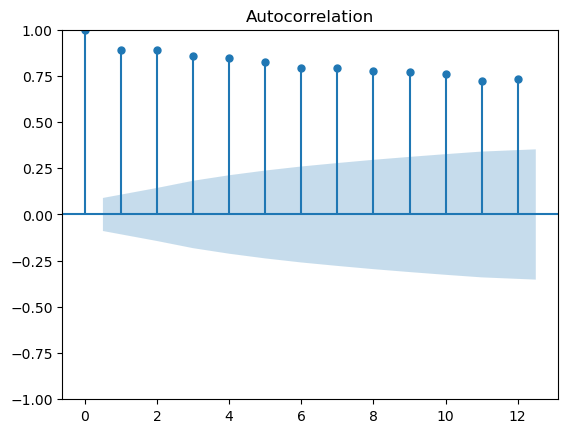

In [55]:
# resampled_data = resample_data(data)

# resampled_data.plot(grid=True)

# plot_acf(resampled_data, alpha=0.05, lags=4)
# plt.show()
plot_acf(data['total'], alpha=0.05, lags=12)
plt.show()

In [56]:
# Run the ADF test on the total building permits series and print out the results
# results = adfuller(resampled_data)
results = adfuller(data['total'])
print("ADF Statistic: %f" % results[0])
print("p-value: %f" % results[1])
print('Critical Values:')
for key, value in results[4].items():
    print('\t%s: %.3f' % (key, value))

p_val = results[1]

# Just print out the p-value
print('The p-value of the building permits data is: ' + str(p_val))

if p_val < 0.05:
    print("We can reject the null hypothesis that the building permits series has a unit root, with 95% confidence. The series is likely stationary.")
else:
    print("We cannot reject the null hypothesis that the building permits series has a unit root, with 95% confidence. The series may be non-stationary.")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


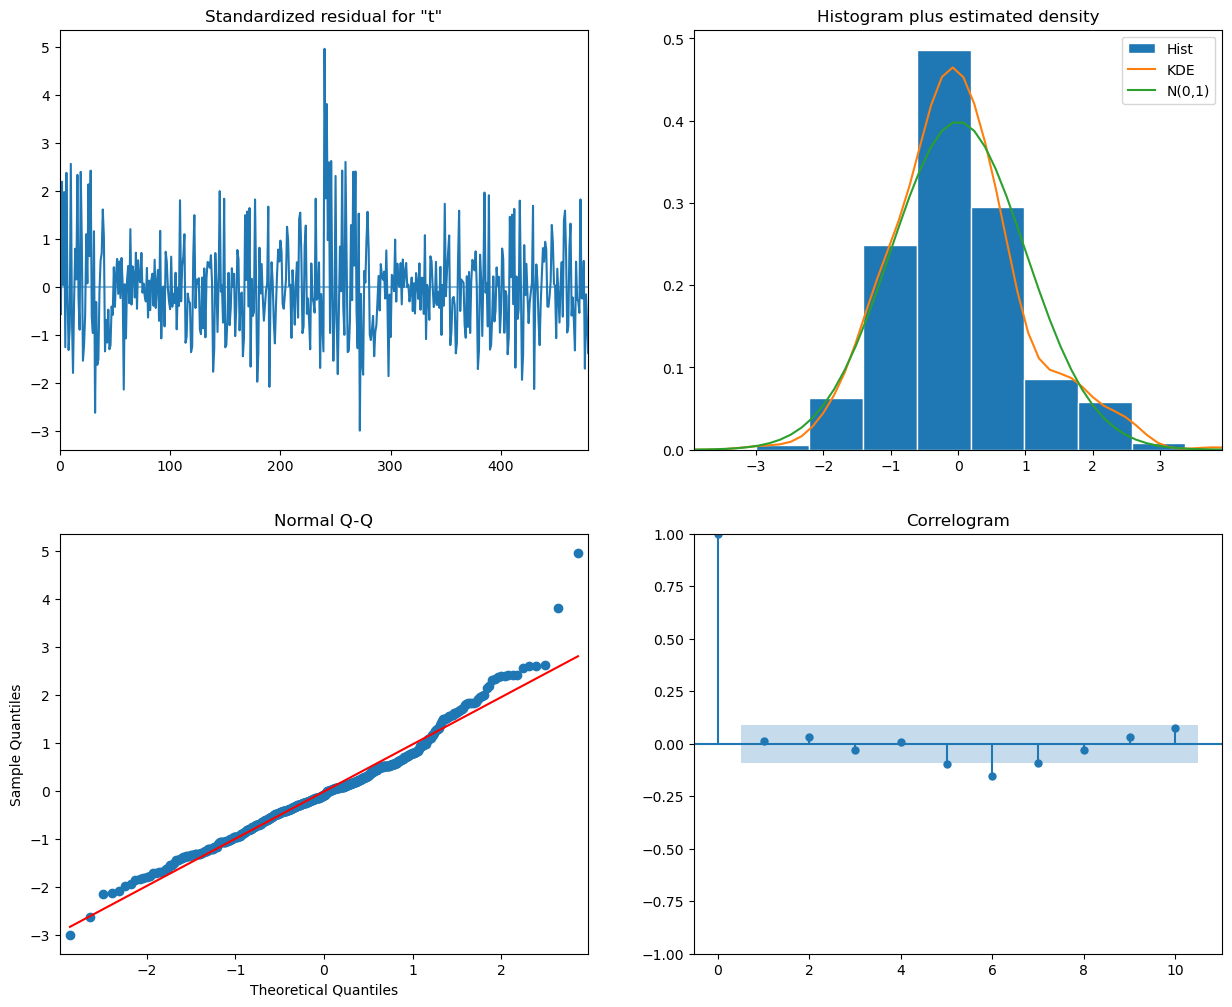

In [57]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# Assuming 'data' is your DataFrame containing the stationary series in 'total' column

# Define the range for p and q parameters
p = range(0, 6)
q = range(0, 6)
pdq = list(itertools.product(p, [0], q))  # [0] for d since your series is stationary

best_aic = float("inf")
best_order = None
best_model = None

for order in pdq:
    try:
        model = ARIMA(data['total'], order=order)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
            best_model = results
    except Exception as e:
        continue

print(f"Best ARIMA{best_order} model AIC: {best_aic}")

# Diagnostic plots for the best model
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


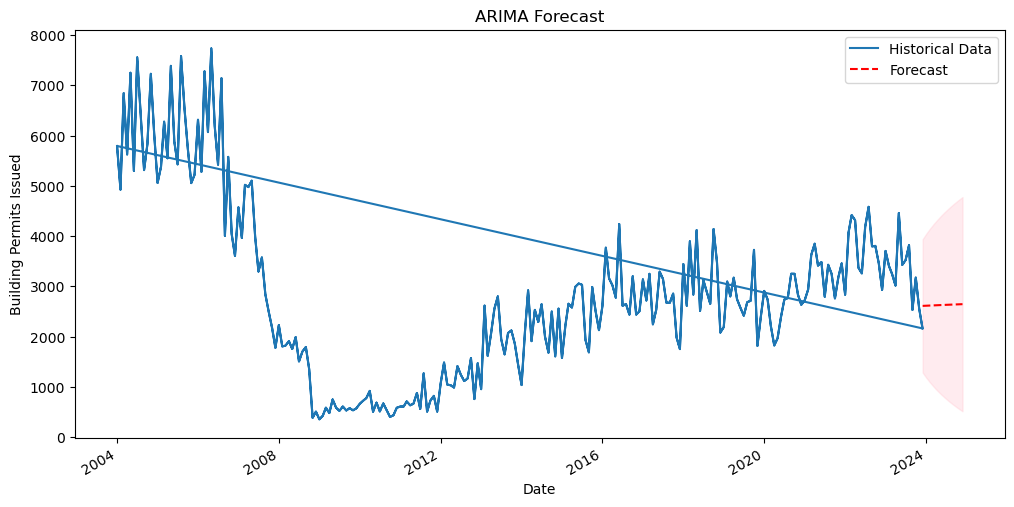

In [58]:
# Assuming 'data' is your DataFrame and 'total' is the column with the time series data
# Ensure your data's index is a DateTimeIndex and properly formatted
data.index = pd.to_datetime(data.index)

# Replace 'best_order' with the tuple (p, d, q) representing your best parameters
# best_order = (1, 0, 1)  # Example, replace with your actual best parameters

# Fit the ARIMA model with the best parameters
model = ARIMA(data['total'], order=best_order)
fit_model = model.fit()

# Make predictions / forecasts
steps_ahead = 12  # Define how many steps ahead you want to forecast
forecast = fit_model.get_forecast(steps=steps_ahead)

# Extract forecast values and confidence intervals
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Align forecast index with the data timeline
forecast_start = data.index[-1] + pd.Timedelta(days=1)
forecast_end = forecast_start + pd.Timedelta(days=steps_ahead * 30)  # Approximate each period as 30 days
forecast_index = pd.date_range(start=forecast_start, end=forecast_end, periods=steps_ahead)
forecast_values.index = forecast_index
confidence_intervals.index = forecast_index

# Plot historical data
plt.figure(figsize=(12, 6))
data['total'].plot(label='Historical Data')

# Plot forecasted values
forecast_values.plot(style='r--', label='Forecast')

# Plot the confidence intervals
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)

plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Building Permits Issued')
plt.legend()
plt.show()
